# Method development for geometric functions

26/02/20

Aims:

- Develop $\beta_{L,M}$ formalism.
- Develop corresponding numerical methods.
- Speed things up (see [low-level benchmarking notebook](https://epsproc.readthedocs.io/en/dev/tests/Low_level_bench_tests_Wigner3j_Feb2020.html)).
- Analyse geometric terms.

## Setup

In [3]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from functools import lru_cache  # For function result caching

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc

# Package fns.
# For module testing, include path to module here
import sys
import os
# modPath = r'D:\code\github\ePSproc'
modPath = r'/home/femtolab/github/ePSproc/'
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc

* pyevtk not found, VTK export not available. 
* plotly not found, plotly plots not available. 


## Exploring Wigner 3js

In photoionization calculations, there is a lot of angular momentum coupling to deal with. Typically, 4 to 6 Wigner 3j terms appear (depending on the formalism), and/or higher-order terms in cases where couplings are included.

\begin{equation}
W = \left(\begin{array}{ccc}
l & l' & L\\
m & m' & M
\end{array}\right)
\end{equation}

Since this is, effectively, a 6D space, dimensions $(l_{max}, l_{max}, 2l_{max}, 2l_{max}+1, 2l_{max}+1, 4l_{max}+1)$ things can get large quickly. For small $l_{max}$ it's easy to look at some values directly...

(For more details on [3j symbols, see Wikipedia](https://en.wikipedia.org/wiki/3-j_symbol); for more on the numerics, see the [test notebook](https://epsproc.readthedocs.io/en/latest/tests/Spherical_function_testing_Aug_2019.html), and [benchmarks](https://epsproc.readthedocs.io/en/latest/tests/Low_level_bench_tests_Wigner3j_Feb2020.html).)

In [47]:
# Calculate some values.
# w3jTable will output all values up to l=lp=Lmax (hence L=2Lmax)
lmax = 1
w3jlist = geomCalc.w3jTable(Lmax = Lmax, form = '2d')  # For form = '2d', the function will output only valid entries as a coordinate table

print(w3jlist.shape)
print(f'Max value: {w3jlist[:,-1].max()}, min value: {w3jlist[:,-1].min()}\n')

# Print the table - output format has rows (l, lp, L, m, mp, M, 3j)
print(w3jlist)

(26, 7)
Max value: 1.0, min value: -0.5773502691896257

[[ 0.          0.          0.          0.          0.          0.
   1.        ]
 [ 0.          1.          1.          0.         -1.          1.
   0.57735027]
 [ 0.          1.          1.          0.          0.          0.
  -0.57735027]
 [ 0.          1.          1.          0.          1.         -1.
   0.57735027]
 [ 1.          0.          1.         -1.          0.          1.
   0.57735027]
 [ 1.          0.          1.          0.          0.          0.
  -0.57735027]
 [ 1.          0.          1.          1.          0.         -1.
   0.57735027]
 [ 1.          1.          2.         -1.         -1.          2.
   0.4472136 ]
 [ 1.          1.          1.         -1.          0.          1.
   0.40824829]
 [ 1.          1.          2.         -1.          0.          1.
  -0.31622777]
 [ 1.          1.          0.         -1.          1.          0.
   0.57735027]
 [ 1.          1.          1.         -1.          1.

Number of valid (non-NaN) elements: <xarray.DataArray 'w3jStacked' ()>
array(26)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


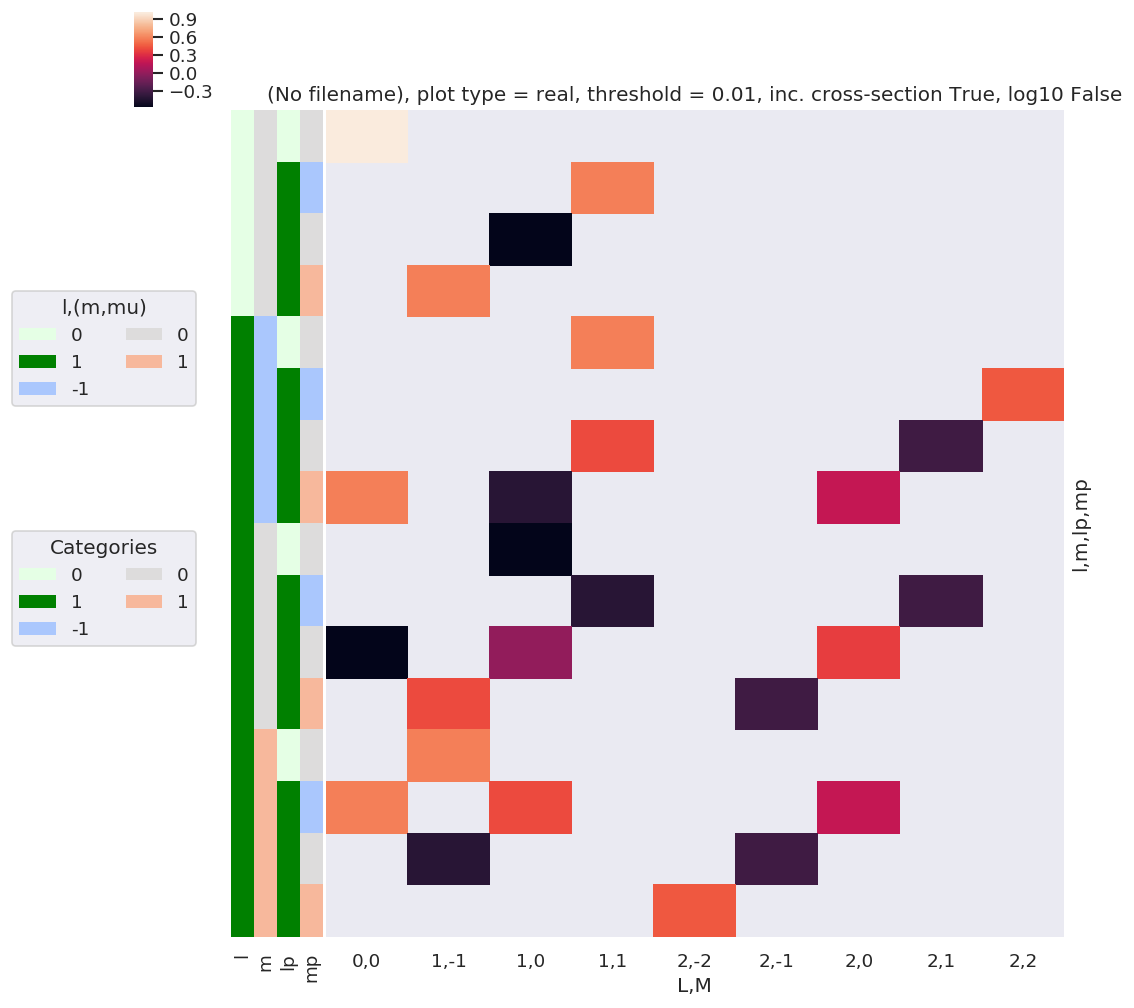

In [48]:
# Recalculate and set to Xarray output format, then plot with ep.lmPlot()

w3j = geomCalc.w3jTable(Lmax = lmax, form = 'xdaLM')

# Check number of valid entries matches basic table above
print(f'Number of valid (non-NaN) elements: {w3j.count()}')

# Set parameters to restack the Xarray into (L,M) pairs
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

In [19]:
# Print out values by QNs (Pandas table)
daPlotpd

L                 0         1                             2            \
M                 0        -1         0         1        -2        -1   
l m  lp mp                                                              
0  0 0   0  1.00000       NaN       NaN       NaN       NaN       NaN   
     1  -1      NaN       NaN       NaN  0.577350       NaN       NaN   
         0      NaN       NaN -0.577350       NaN       NaN       NaN   
         1      NaN  0.577350       NaN       NaN       NaN       NaN   
1 -1 0   0      NaN       NaN       NaN  0.577350       NaN       NaN   
     1  -1      NaN       NaN       NaN       NaN       NaN       NaN   
         0      NaN       NaN       NaN  0.408248       NaN       NaN   
         1  0.57735       NaN -0.408248       NaN       NaN       NaN   
   0 0   0      NaN       NaN -0.577350       NaN       NaN       NaN   
     1  -1      NaN       NaN       NaN -0.408248       NaN       NaN   
         0 -0.57735       NaN  0.000000       NaN       NaN       NaN   
         1      NaN  0.408248       NaN       NaN       NaN -0.316228   
   1 0   0      NaN  0.577350       NaN       NaN       NaN       NaN   
     1  -1  0.57735       NaN  0.408248       NaN       NaN       NaN   
         0      NaN -0.408248       NaN       NaN       NaN -0.316228   
         1      NaN       NaN       NaN       NaN  0.447214       NaN   

L                                         
M                  0         1         2  
l m  lp mp                                
0  0 0   0       NaN       NaN       NaN  
     1  -1       NaN       NaN       NaN  
         0       NaN       NaN       NaN  
         1       NaN       NaN       NaN  
1 -1 0   0       NaN       NaN       NaN  
     1  -1       NaN       NaN  0.447214  
         0       NaN -0.316228       NaN  
         1  0.182574       NaN       NaN  
   0 0   0       NaN       NaN       NaN  
     1  -1       NaN -0.316228       NaN  
         0  0.365148       NaN       NaN  
         1       NaN       NaN       NaN  
   1 0   0       NaN       NaN       NaN  
     1  -1  0.182574       NaN       NaN  
         0       NaN       NaN       NaN  
         1       NaN       NaN       NaN

This ends up as a relatively sparse array, since many combinations are invalid (do not follow angular momentum selection rules), hence there are many NaN terms.

The results can also be output as a 6D sparse array, using the [Sparse library](https://sparse.pydata.org/en/latest/index.html).

In [26]:
# Calculate and output in Sparse array format
w3jSparse = geomCalc.w3jTable(Lmax = lmax, form = 'ndsparse')
w3jSparse

Format,coo
Data Type,float64
Shape,"(2, 2, 3, 2, 2, 3)"
nnz,25
Density,0.1736111111111111
Read-only,True
Size,1.4K
Storage ratio,1.2


Here `nnz` is the number of non-zero elements.

Number of valid (non-NaN) elements: <xarray.DataArray 'w3jStacked' ()>
array(820)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


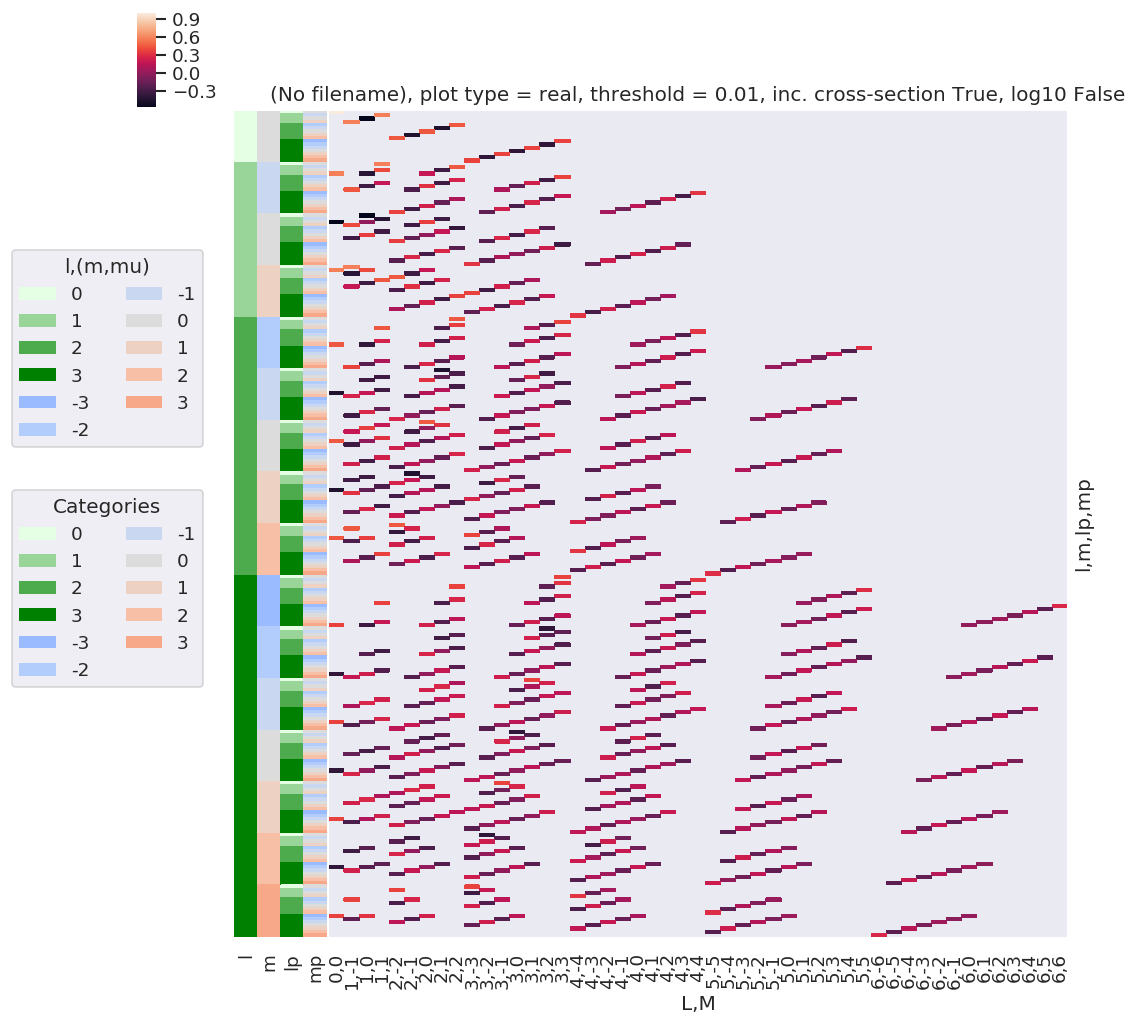

In [52]:
# Try a larger Lmax and plot only.
lmax = 3
w3j = geomCalc.w3jTable(Lmax = lmax, form = 'xdaLM')

# Check number of valid entries matches basic table above
print(f'Number of valid (non-NaN) elements: {w3j.count()}')

# Set parameters to restack the Xarray into (L,M) pairs
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


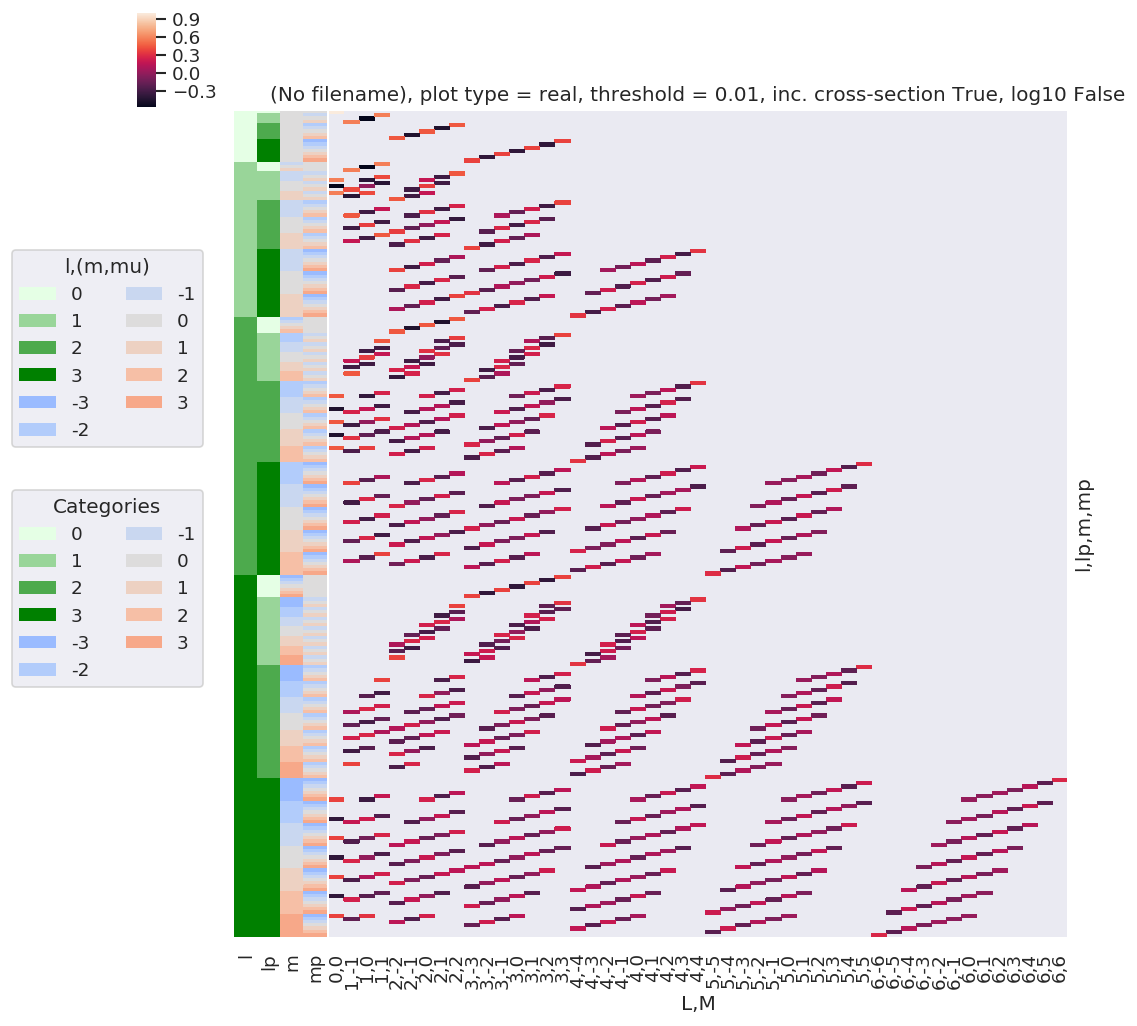

In [57]:
# Resort axis by (l,lp)
plotDimsRed = ['l', 'lp', 'm', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

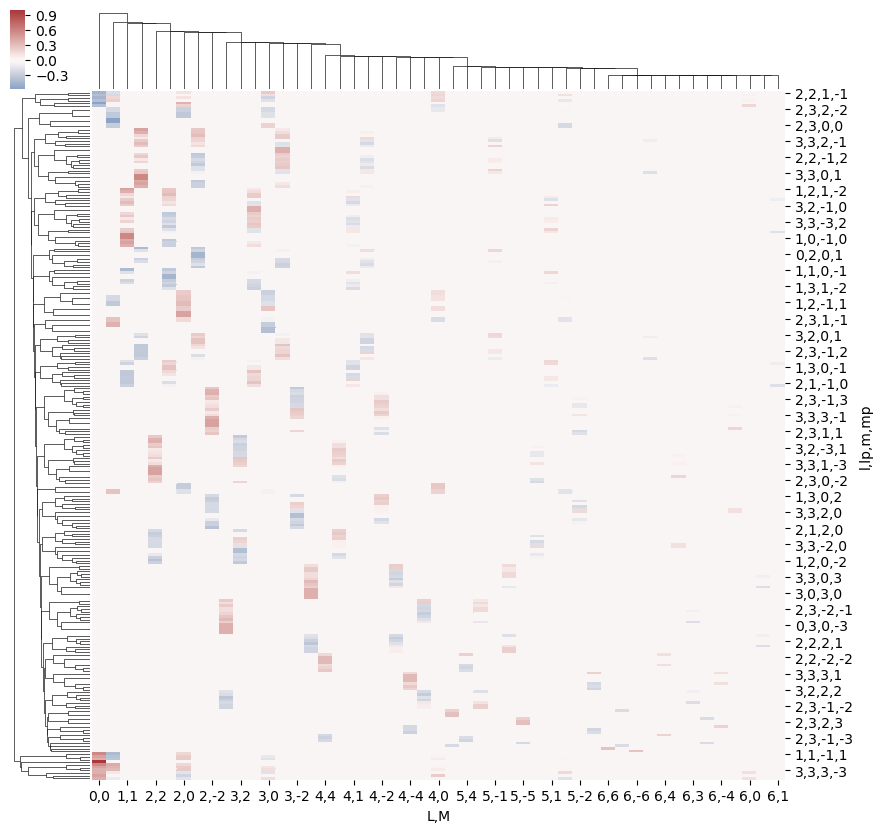

In [65]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
ep.snsMatMod.clustermap(daPlotpd.fillna(0), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

This clearly shows that the valid terms become sparser at higher $l$, and the couplings become smaller.

Structure can also be examined using other methods, e.g. correlation functions (see, for example, [Seaborn Discovering structure in heatmap data](https://seaborn.pydata.org/examples/structured_heatmap.html). The example here shows [Panda's standard Pearson correlation coefficient](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#correlation), which may (or may not) be particularly meaningful here... but does show structures.

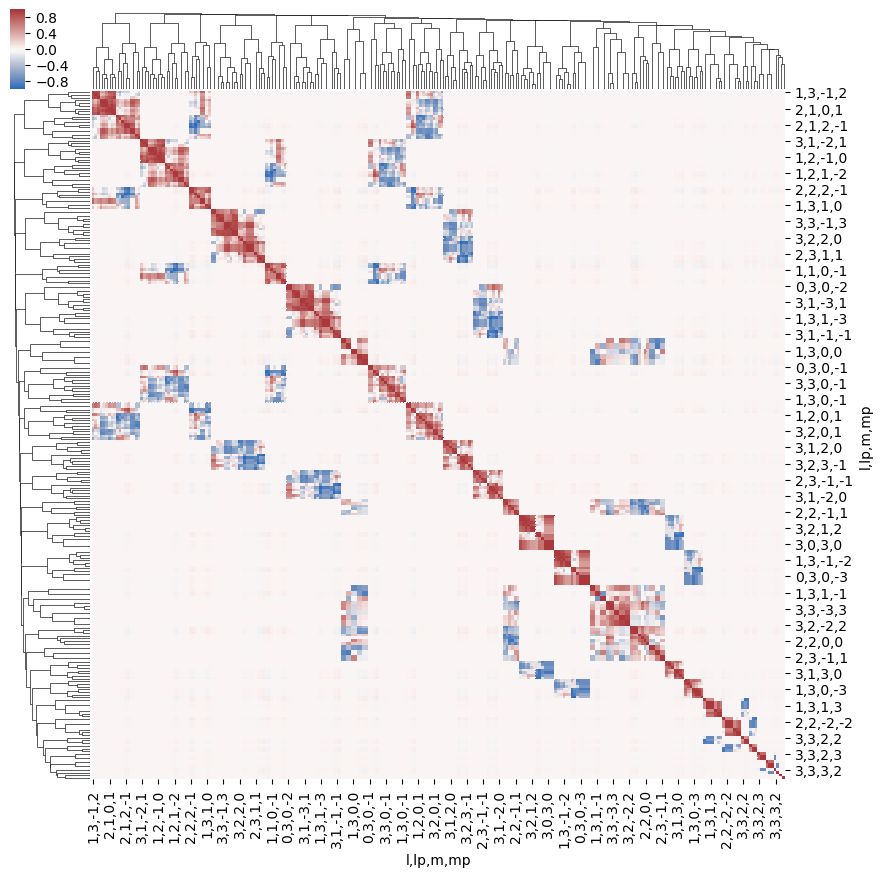

In [67]:
ep.snsMatMod.clustermap(daPlotpd.fillna(0).T.corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


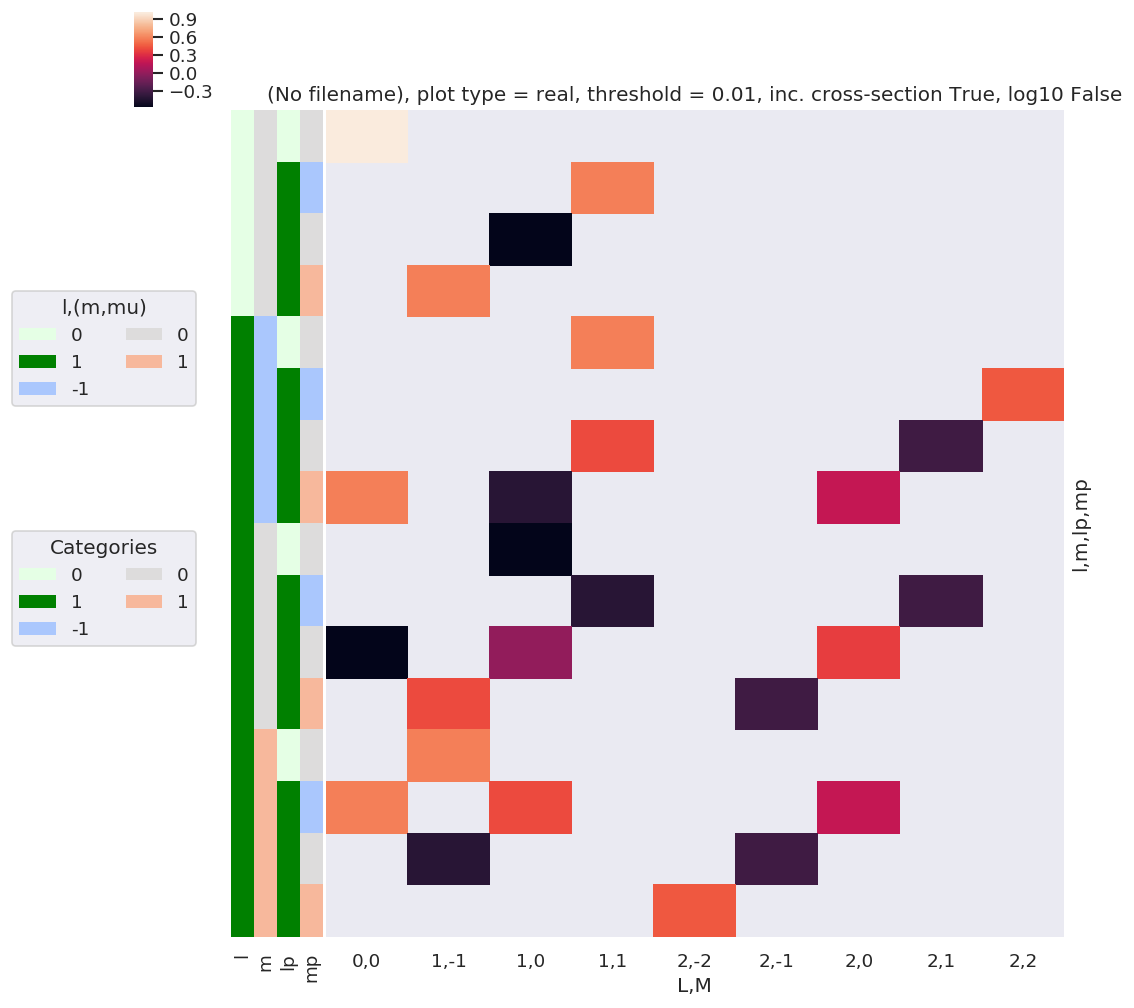

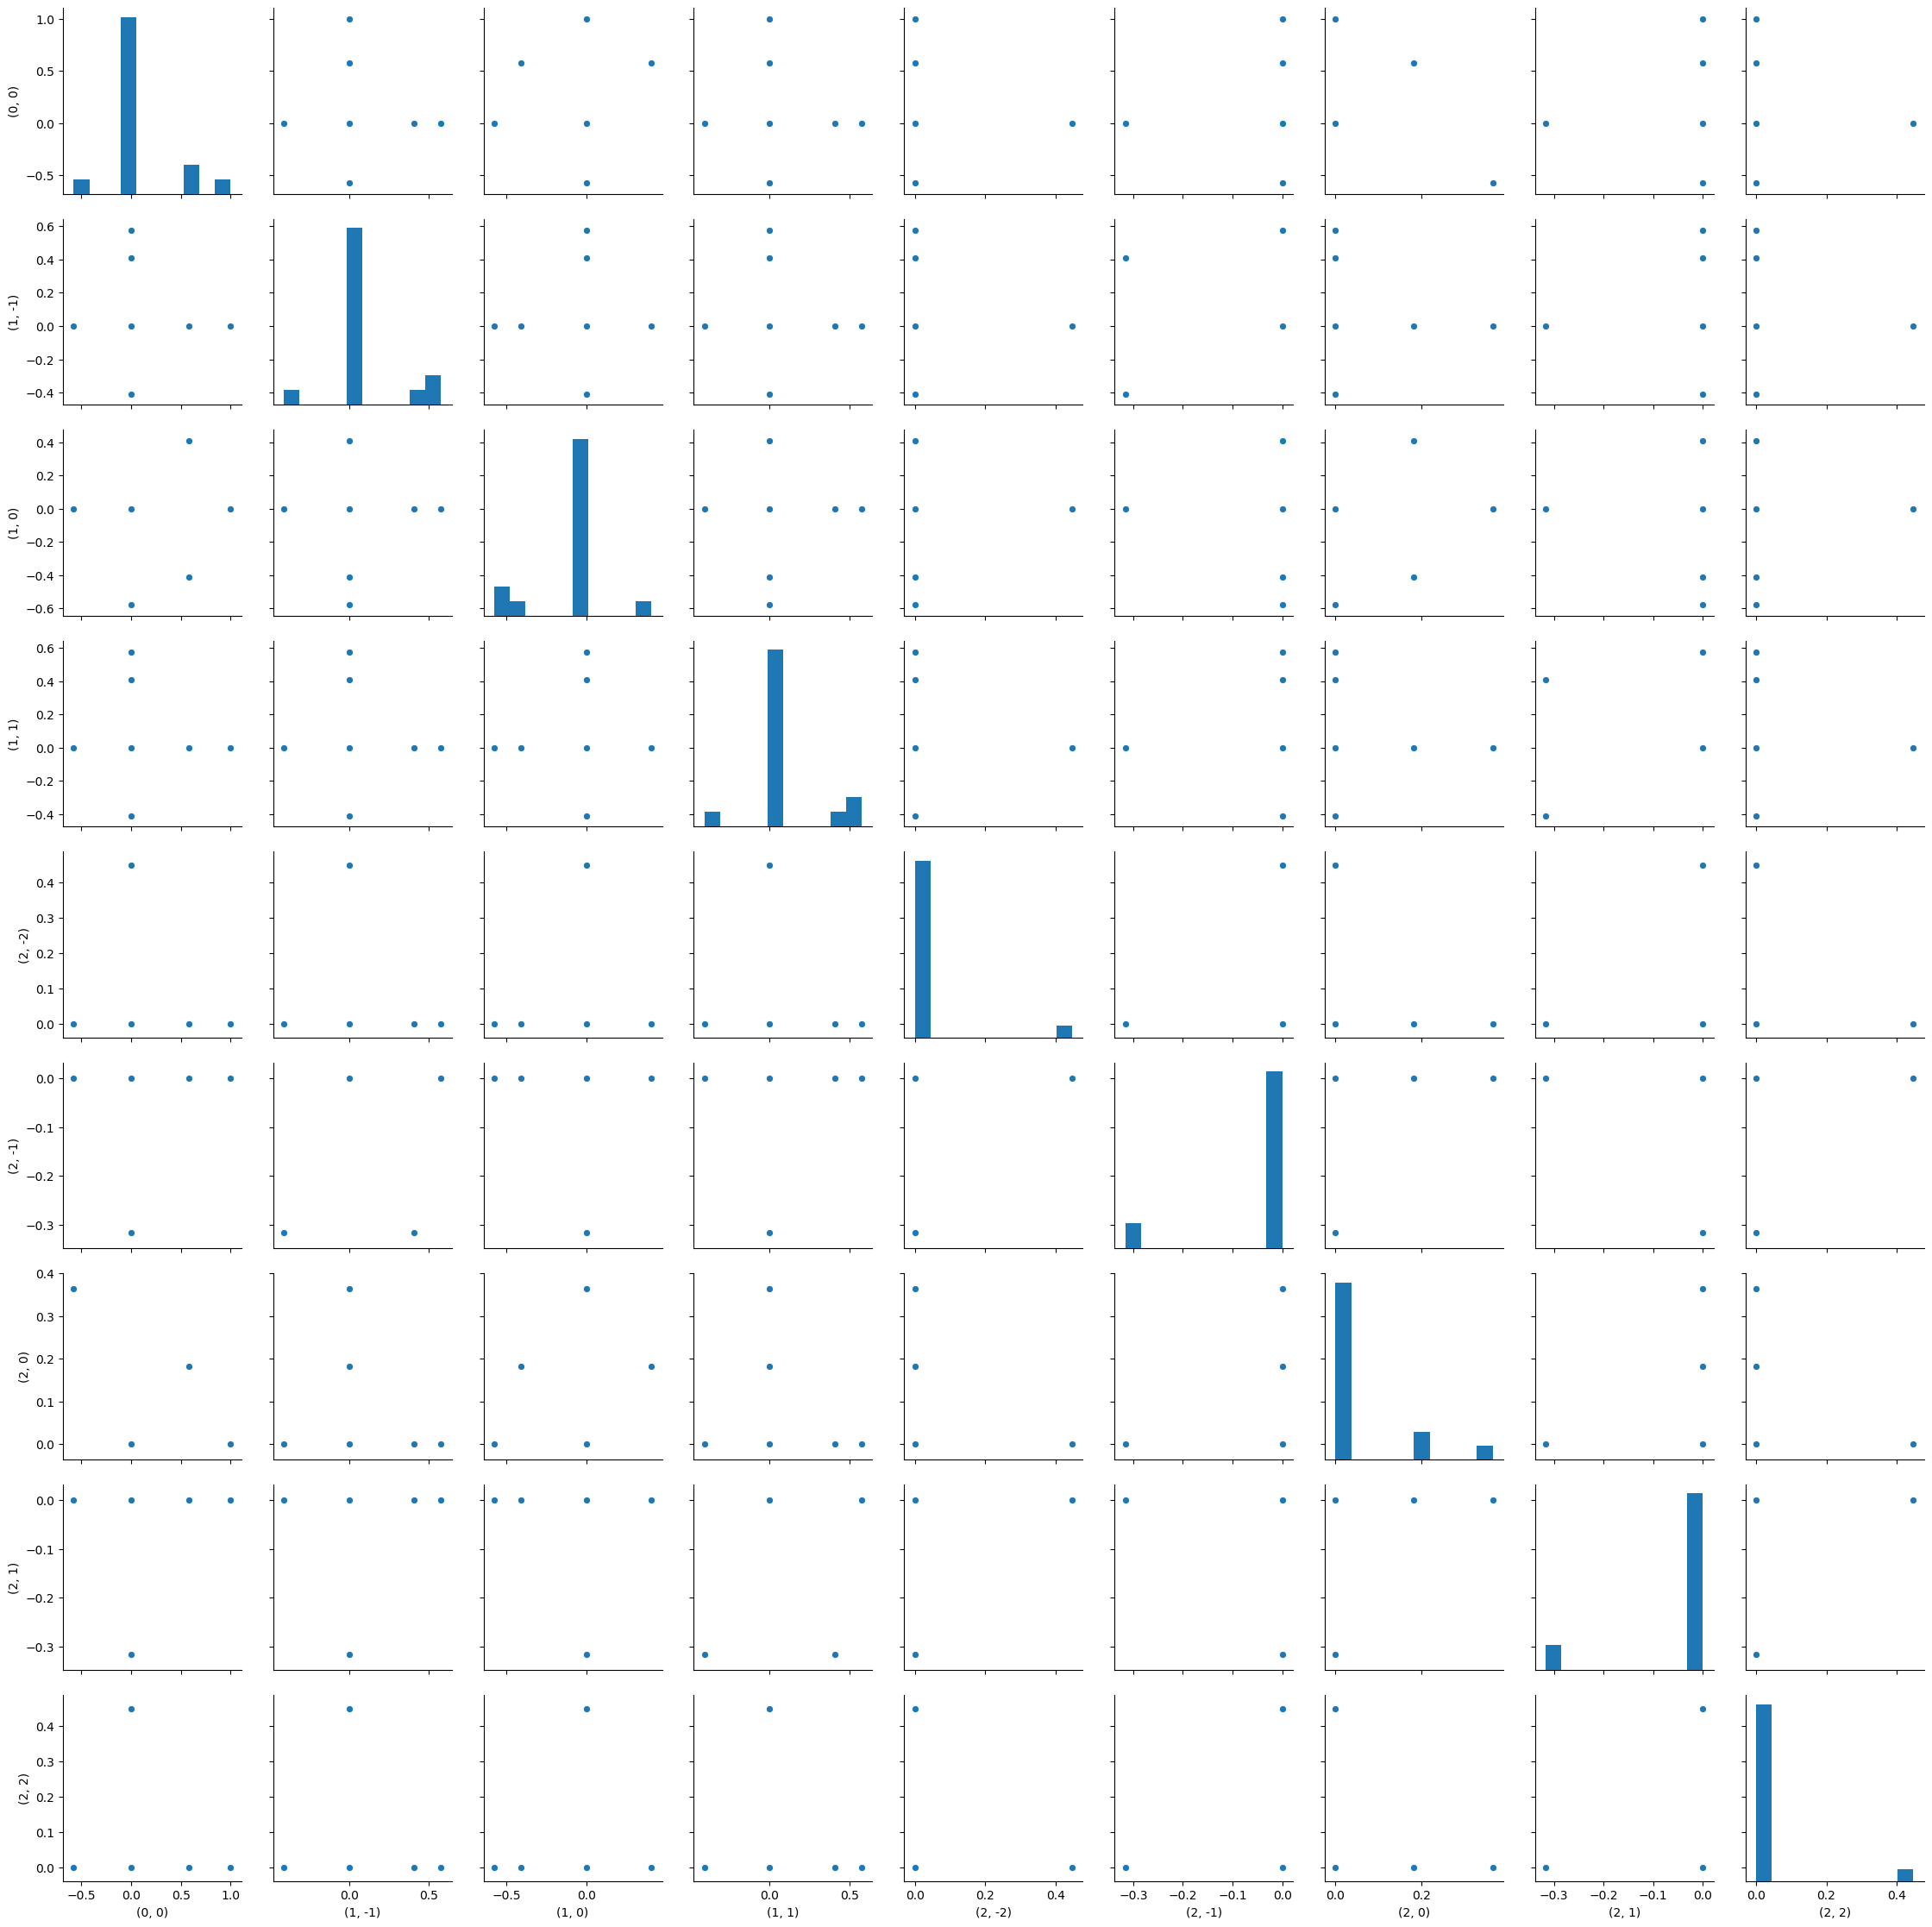

In [78]:
# Test some other Seaborn methods... these likely won't scale well for large lmax!
import seaborn as sns

# Recalculate for small lmax
lmax = 1
w3j = geomCalc.w3jTable(Lmax = lmax, form = 'xdaLM')

# Set parameters to restack the Xarray into (L,M) pairs
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3j, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

# Try sns pairplot
# sns.pairplot(daPlotpd.fillna(0).T)  # Big grids!
sns.pairplot(daPlotpd.fillna(0))  # OK, not particularly informative
# sns.pairplot(daPlotpd.fillna(0), hue = 'l')  # Doesn't work - multindex issue?

## $E_{P,R}$ tensor

The coupling of two 1-photon terms can be written as a tensor contraction:

\begin{equation}
E_{PR}(\hat{e})=[e\otimes e^{*}]_{R}^{P}=[P]^{\frac{1}{2}}\sum_{p}(-1)^{R}\left(\begin{array}{ccc}
1 & 1 & P\\
p & R-p & -R
\end{array}\right)e_{p}e_{R-p}^{*}\label{eq:EPR-defn-1}
\end{equation}

Where $e_{p}$ and $e_{R-p}$ define the field strengths for the polarizations $p$ and $R-p$, which are coupled into the spherical tensor $E_{PR}$.


In [5]:
# Calculate EPR terms, all QNs, with field strengths e = 1
EPRtable = geomCalc.EPR(form = '2d')

# Output values as list, [l, lp, P, p, R-p, R, EPR]
print(EPRtable)

[[ 1.          1.          0.         -1.          1.          0.
   0.57735027]
 [ 1.          1.          1.         -1.          0.          1.
  -0.70710678]
 [ 1.          1.          1.         -1.          1.          0.
  -0.70710678]
 [ 1.          1.          2.         -1.         -1.          2.
   1.        ]
 [ 1.          1.          2.         -1.          0.          1.
   0.70710678]
 [ 1.          1.          2.         -1.          1.          0.
   0.40824829]
 [ 1.          1.          0.          0.          0.          0.
  -0.57735027]
 [ 1.          1.          1.          0.         -1.          1.
   0.70710678]
 [ 1.          1.          1.          0.          1.         -1.
  -0.70710678]
 [ 1.          1.          2.          0.         -1.          1.
   0.70710678]
 [ 1.          1.          2.          0.          0.          0.
   0.81649658]
 [ 1.          1.          2.          0.          1.         -1.
   0.70710678]
 [ 1.          1.          0

As before, we can visualise these values...

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


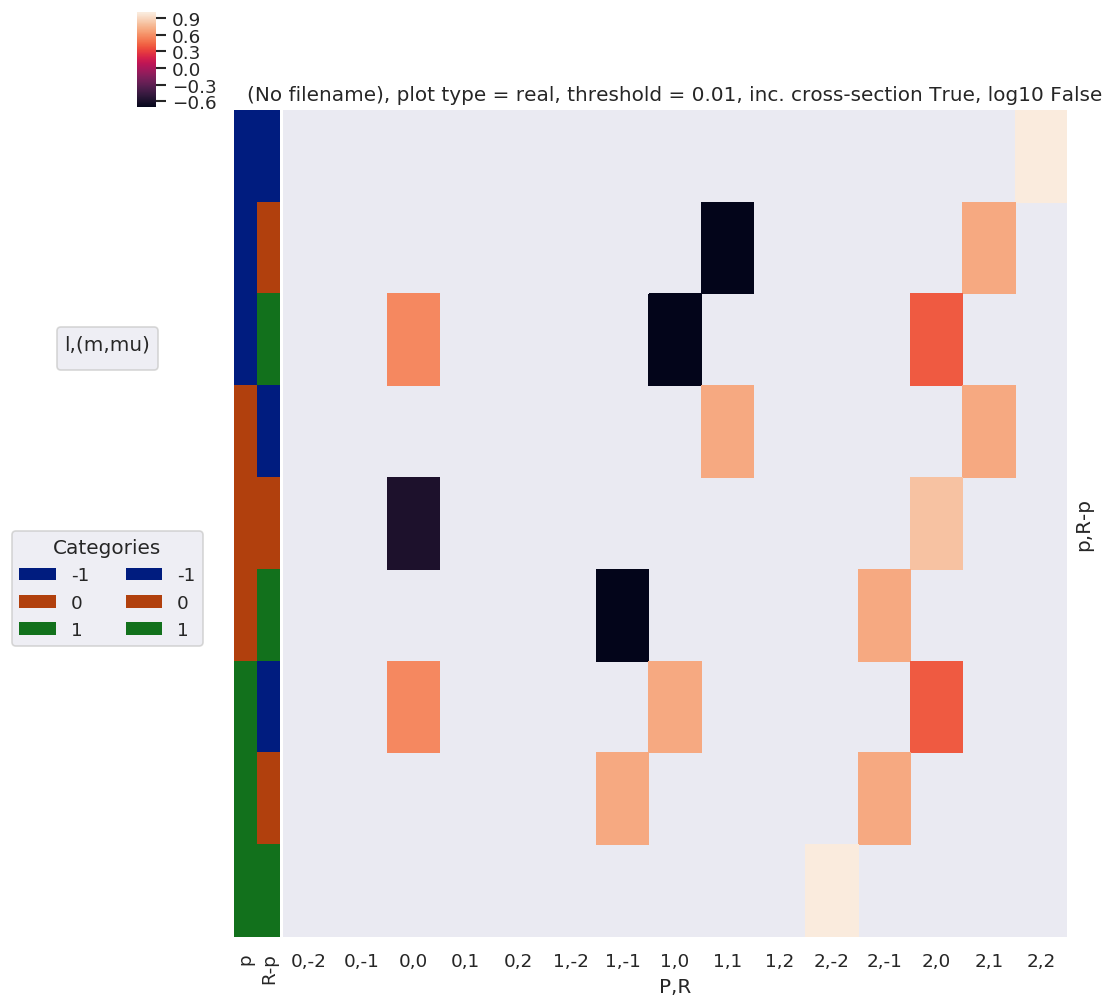

In [9]:
EPRX = geomCalc.EPR(form = 'xarray')

# Set parameters to restack the Xarray into (L,M) pairs
# plotDimsRed = ['l', 'p', 'lp', 'R-p']
plotDimsRed = ['p', 'R-p']
xDim = {'PR':['P','R']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(EPRX, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

# Seem to have some all-NaN cols persisting here, not sure why...

In [16]:
# Tabulate
daPlotpd.dropna(axis = 1, how = 'all')

P             0         1                        2                      \
R             0        -1         0         1   -2        -1         0   
p  R-p                                                                   
-1 -1       NaN       NaN       NaN       NaN  NaN       NaN       NaN   
    0       NaN       NaN       NaN -0.707107  NaN       NaN       NaN   
    1   0.57735       NaN -0.707107       NaN  NaN       NaN  0.408248   
 0 -1       NaN       NaN       NaN  0.707107  NaN       NaN       NaN   
    0  -0.57735       NaN       NaN       NaN  NaN       NaN  0.816497   
    1       NaN -0.707107       NaN       NaN  NaN  0.707107       NaN   
 1 -1   0.57735       NaN  0.707107       NaN  NaN       NaN  0.408248   
    0       NaN  0.707107       NaN       NaN  NaN  0.707107       NaN   
    1       NaN       NaN       NaN       NaN  1.0       NaN       NaN   

P                      
R              1    2  
p  R-p                 
-1 -1        NaN  1.0  
    0   0.707107  NaN  
    1        NaN  NaN  
 0 -1   0.707107  NaN  
    0        NaN  NaN  
    1        NaN  NaN  
 1 -1        NaN  NaN  
    0        NaN  NaN  
    1        NaN  NaN

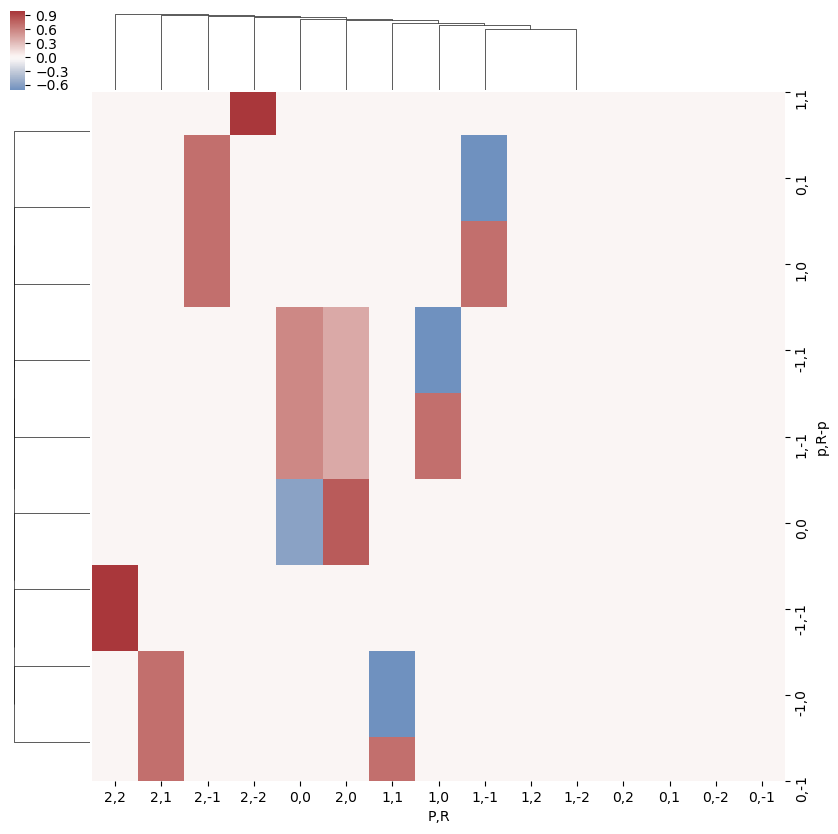

In [17]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
ep.snsMatMod.clustermap(daPlotpd.fillna(0), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

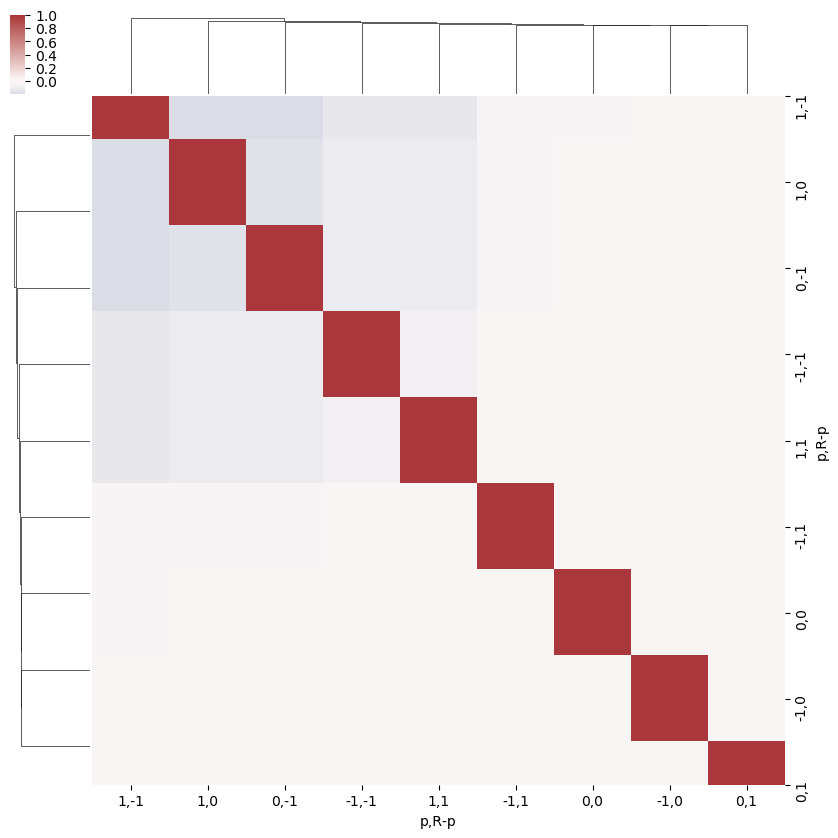

In [21]:
ep.snsMatMod.clustermap(daPlotpd.fillna(0).T.corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

## $B_{L,M}$ term

The coupling of the partial wave pairs, $|l,m\rangle$ and $|l',m'\rangle$, into the observable set of $\{L,M\}$ is defined by a tensor contraction with two 3j terms.

\begin{equation}
B_{L,M}=(-1)^{m}\left(\frac{(2l+1)(2l'+1)(2L+1)}{4\pi}\right)^{1/2}\left(\begin{array}{ccc}
l & l' & L\\
0 & 0 & 0
\end{array}\right)\left(\begin{array}{ccc}
l & l' & L\\
-m & m' & M
\end{array}\right)
\end{equation}

(See notebook ePSproc_wigner3j_dataStructures_260220.ipynb on Bemo for additonal dev details)

In [22]:
Lmax = 1
BLMtable = geomCalc.betaTerm(Lmax = Lmax, form = 'xdaLM')  # Output as stacked Xarray

In [23]:
BLMtable

<xarray.DataArray 'w3jStacked' (lSet: 6, mSet: 9)>
array([[        nan,         nan,         nan,         nan,  0.28209479,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan, -0.28209479,  0.28209479,
        -0.28209479,         nan,         nan,         nan],
       [        nan,  0.28209479,         nan,         nan,  0.28209479,
                nan,         nan,  0.28209479,         nan],
       [        nan,         nan,  0.28209479,         nan,  0.28209479,
                nan,  0.28209479,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan],
       [-0.30901936,  0.21850969, -0.12615663, -0.21850969,  0.25231325,
        -0.21850969, -0.12615663,  0.21850969, -0.30901936]])
Coordinates:
  * mSet     (mSet) MultiIndex
  - m        (mSet) int64 -1 -1 -1 0 0 0 1 1 1
  - mp       (mSet) int64 -1 0 1 -1 0 1 -1 0 1
  - M 

In [26]:
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
# daPlot = BLMtable.unstack().stack({'LM':['L','M']})
# ep.lmPlot(w3jXcombMult.unstack().stack({'LM':['l','m']}), plotDims=['lp', 'L', 'mp', 'M'], xDim='LM', SFflag = False)
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable.unstack().stack(xDim), plotDims=plotDimsRed, xDim=xDim, SFflag = False, squeeze = False)
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, plotDims=plotDimsRed, xDim=xDim)
# ep.lmPlot(w3jXcombMult.unstack(), plotDims=['lp', 'L', 'mp', 'M'], xDim='L', SFflag = False)

# daPlotpd = daPlot.unstack().stack(plotDim = plotDimsRed).to_pandas().dropna(axis = 1).T

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Plotting data (No filename), pType=r, thres=0.01, with Seaborn


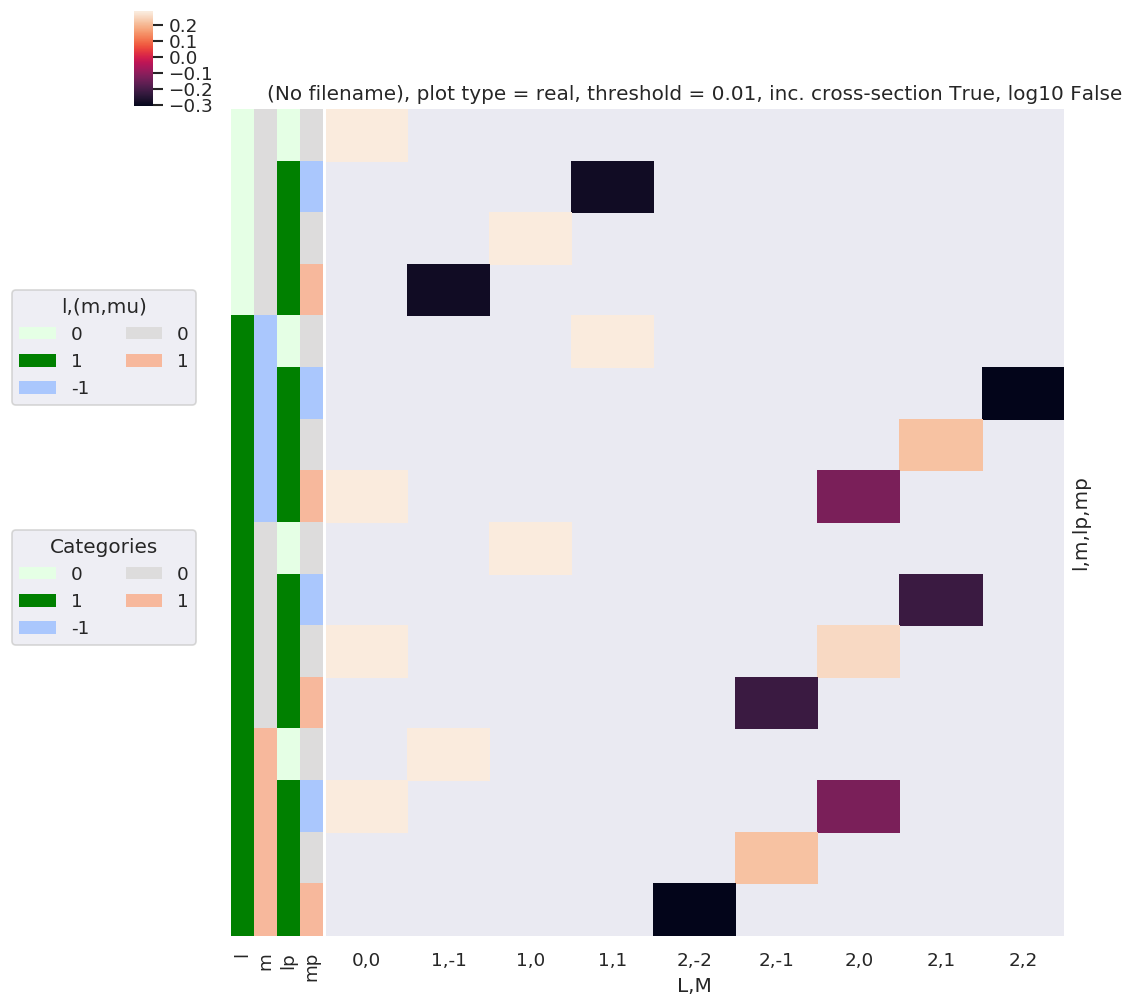

In [27]:
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable.unstack().stack(xDim), plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, plotDims=plotDimsRed, xDim=xDim, pType = 'r')

In [28]:
daPlotpd

L                  0         1                             2           \
M                  0        -1         0         1        -2       -1   
l m  lp mp                                                              
0  0 0   0  0.282095       NaN       NaN       NaN       NaN      NaN   
     1  -1       NaN       NaN       NaN -0.282095       NaN      NaN   
         0       NaN       NaN  0.282095       NaN       NaN      NaN   
         1       NaN -0.282095       NaN       NaN       NaN      NaN   
1 -1 0   0       NaN       NaN       NaN  0.282095       NaN      NaN   
     1  -1       NaN       NaN       NaN       NaN       NaN      NaN   
         0       NaN       NaN       NaN       NaN       NaN      NaN   
         1  0.282095       NaN       NaN       NaN       NaN      NaN   
   0 0   0       NaN       NaN  0.282095       NaN       NaN      NaN   
     1  -1       NaN       NaN       NaN       NaN       NaN      NaN   
         0  0.282095       NaN       NaN       NaN       NaN      NaN   
         1       NaN       NaN       NaN       NaN       NaN -0.21851   
   1 0   0       NaN  0.282095       NaN       NaN       NaN      NaN   
     1  -1  0.282095       NaN       NaN       NaN       NaN      NaN   
         0       NaN       NaN       NaN       NaN       NaN  0.21851   
         1       NaN       NaN       NaN       NaN -0.309019      NaN   

L                                        
M                  0        1         2  
l m  lp mp                               
0  0 0   0       NaN      NaN       NaN  
     1  -1       NaN      NaN       NaN  
         0       NaN      NaN       NaN  
         1       NaN      NaN       NaN  
1 -1 0   0       NaN      NaN       NaN  
     1  -1       NaN      NaN -0.309019  
         0       NaN  0.21851       NaN  
         1 -0.126157      NaN       NaN  
   0 0   0       NaN      NaN       NaN  
     1  -1       NaN -0.21851       NaN  
         0  0.252313      NaN       NaN  
         1       NaN      NaN       NaN  
   1 0   0       NaN      NaN       NaN  
     1  -1 -0.126157      NaN       NaN  
         0       NaN      NaN       NaN  
         1       NaN      NaN       NaN

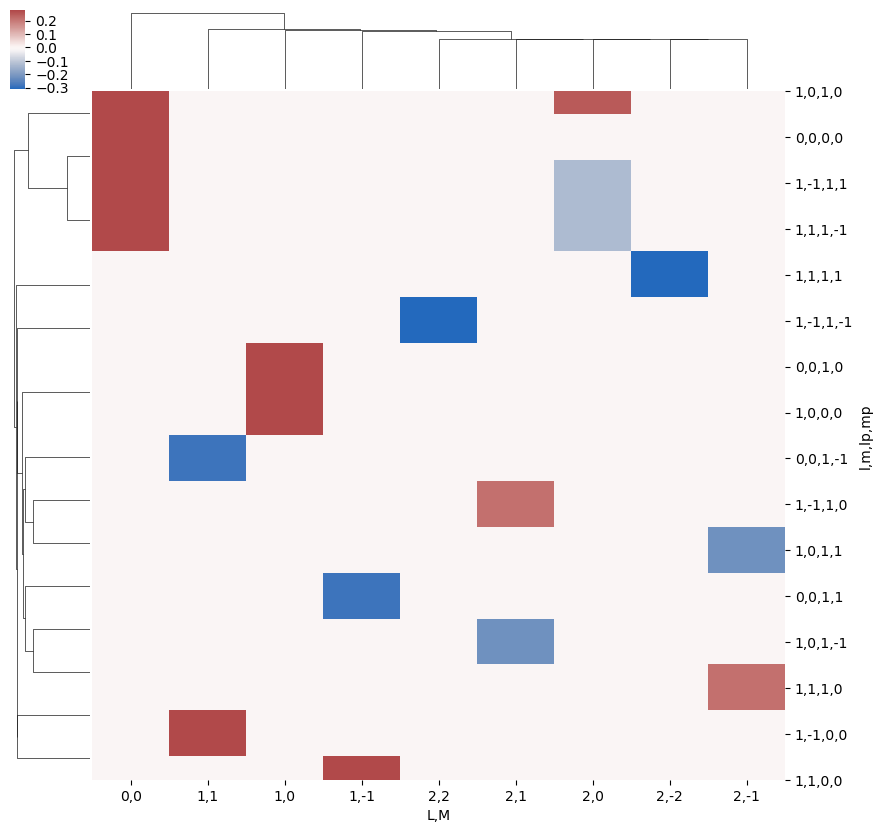

In [32]:
# A complementary visulization is to call directly the sns.clustermap plot, use clustering and plot by category labels - see https://seaborn.pydata.org/index.html
# (ep.lpPlot uses a modified version of this routine.)
ep.snsMatMod.clustermap(daPlotpd.fillna(0).T, center=0, cmap="vlag", row_cluster=True, col_cluster=True)

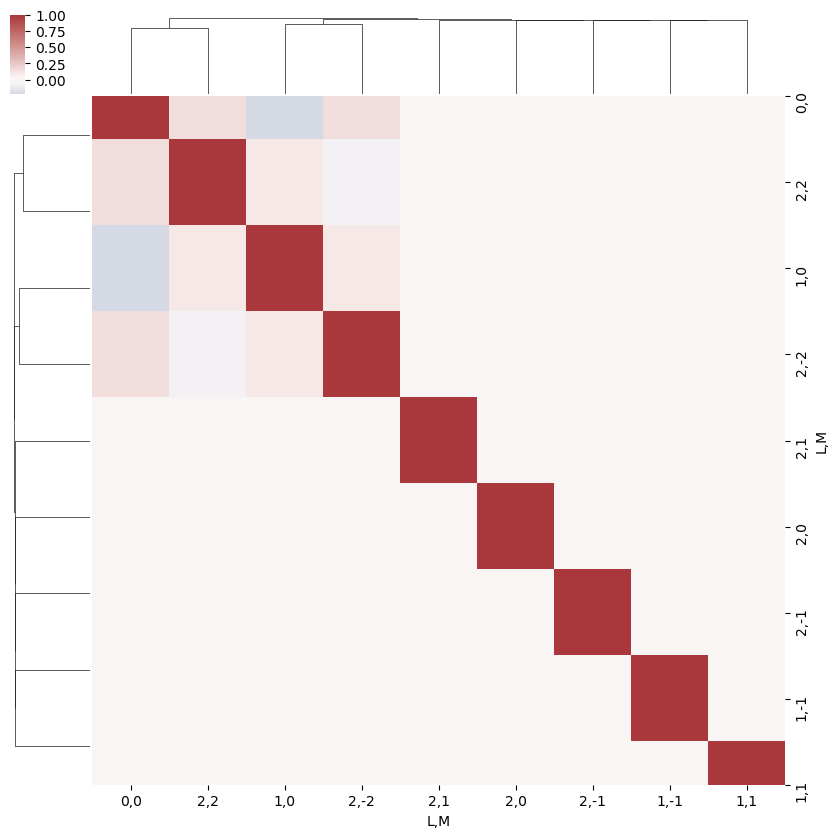

In [33]:
ep.snsMatMod.clustermap(daPlotpd.fillna(0).T.corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

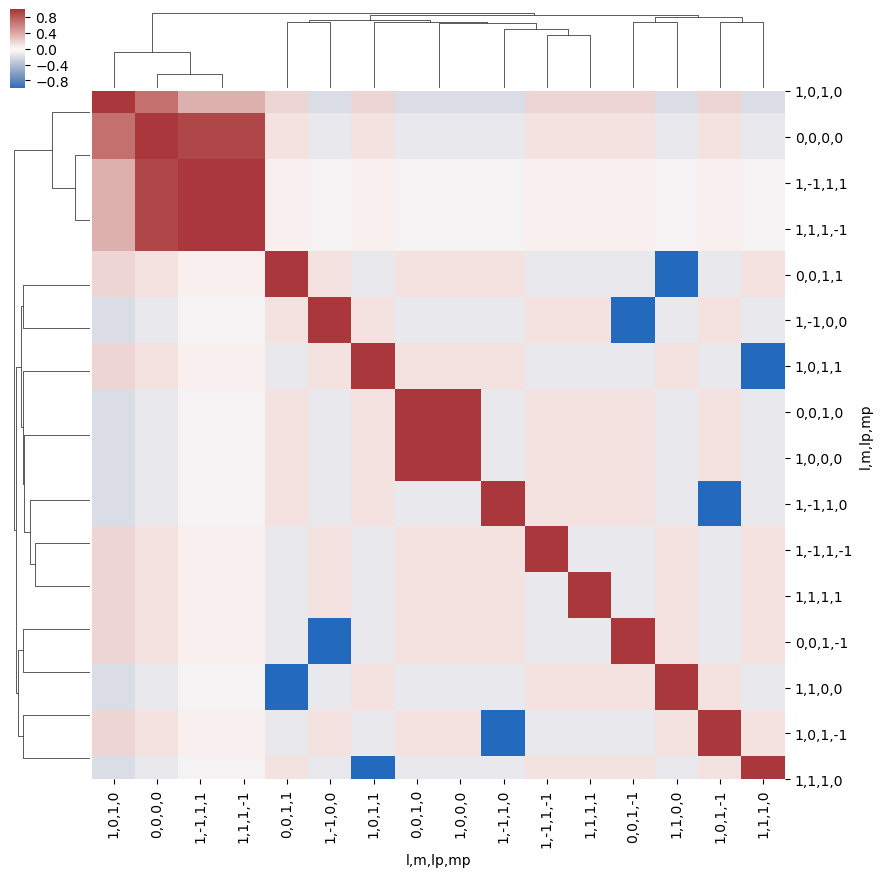

In [34]:
ep.snsMatMod.clustermap(daPlotpd.fillna(0).corr(), center=0, cmap="vlag", row_cluster=True, col_cluster=True)

What do we learn here...?  This is a nice way to visualize the selection rules into the observable: for instance, only terms $l=l'$ and $m=-m'$ contribute to the overall photoinoization cross-section term ($L=0, M=0$). However, since these terms are fairly simply followed algebraically in this case, via the rules inherent in the 3j product, this is not particularly insightful. These visualizations will become more useful when dealing with real sets of matrix elements, and specific polarization geometries, which will further modulate the $B_{L,M}$ terms.

In [11]:
# NOW FIXED
# Test PD conversion - seems to be giving issue for lmPlot() routine here.
# daPlotpd = daPlot.stack(plotDim = plotDimsRed).to_pandas().T
# daPlotpd = daPlot.stack(plotDim = plotDimsRed).to_pandas().dropna(axis = 0).T  # Drop na here seems to remove everything - might be issue in lmPlot

# daPlotpd = daPlot.stack(plotDim = plotDimsRed).dropna(dim='plotDim', how='all').to_pandas().T  # This seems to reduce NaNs OK
# daPlotpd = daPlot.stack(xDim).stack(plotDim = plotDimsRed).dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').to_pandas().T  # This seems to reduce NaNs OK

# daPlotpd

In [12]:
# Test reductions by # of non-Nan elements
# print(daPlot.count())
# print(daPlot.stack(plotDim = plotDimsRed).dropna(dim='plotDim', how='any').count())   # how='any' will drop all elements it seems.
# print(daPlot.stack(plotDim = plotDimsRed).dropna(dim='plotDim', how='all').count()) 
# print(daPlot.stack(plotDim = plotDimsRed).dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').count())
print(daPlot.count())
print(daPlot.dropna(dim='plotDim', how='any').count())   # how='any' will drop all elements it seems.
print(daPlot.dropna(dim='plotDim', how='all').count()) 
print(daPlot.dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').count())

<xarray.DataArray 'w3jStacked' ()>
array(19)
<xarray.DataArray 'w3jStacked' ()>
array(0)
<xarray.DataArray 'w3jStacked' ()>
array(19)
<xarray.DataArray 'w3jStacked' ()>
array(19)


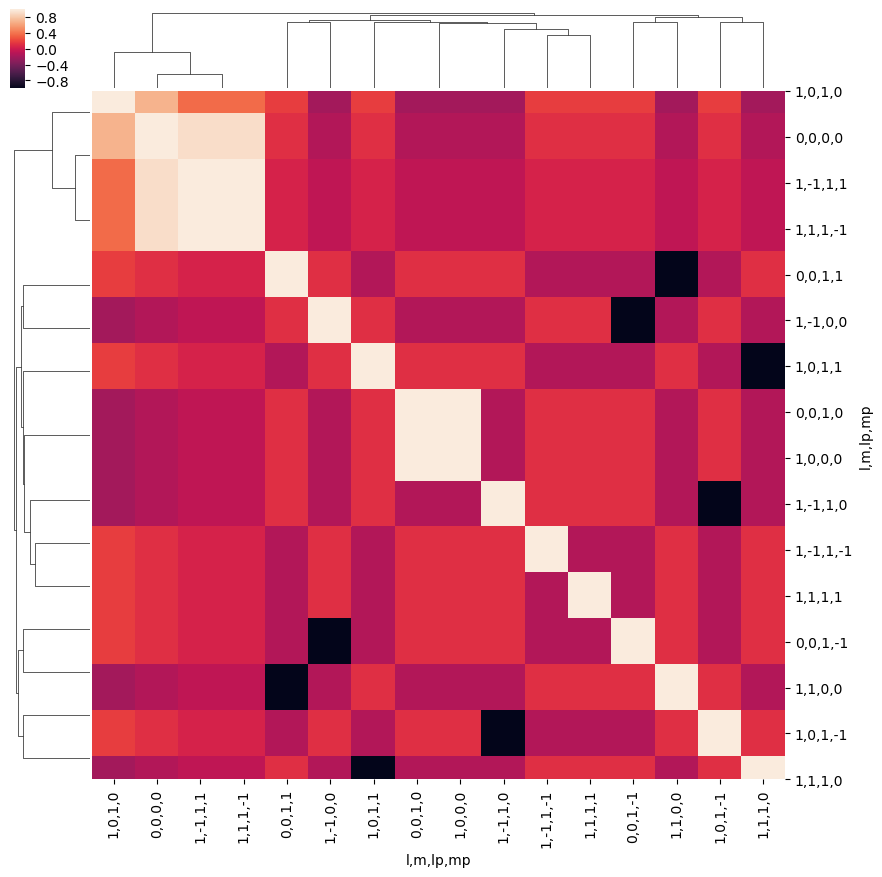

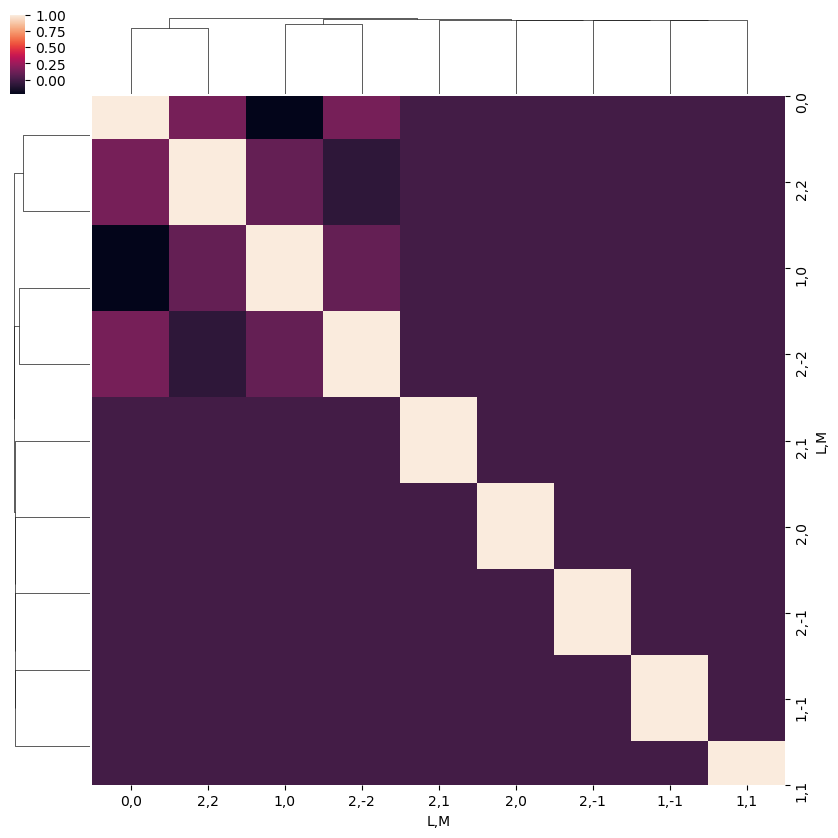

In [29]:
# Test correlation fns.
# This fails with NaNs present it seems
# ep.snsMatMod.clustermap(daPlot.dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').fillna(0).to_pandas().T.corr())
# ep.snsMatMod.clustermap(daPlot.dropna(dim='plotDim', how='all').dropna(dim='LM',how='all').fillna(0).to_pandas().corr())
ep.snsMatMod.clustermap(daPlotpd.fillna(0).T.corr())
ep.snsMatMod.clustermap(daPlotpd.fillna(0).corr())

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


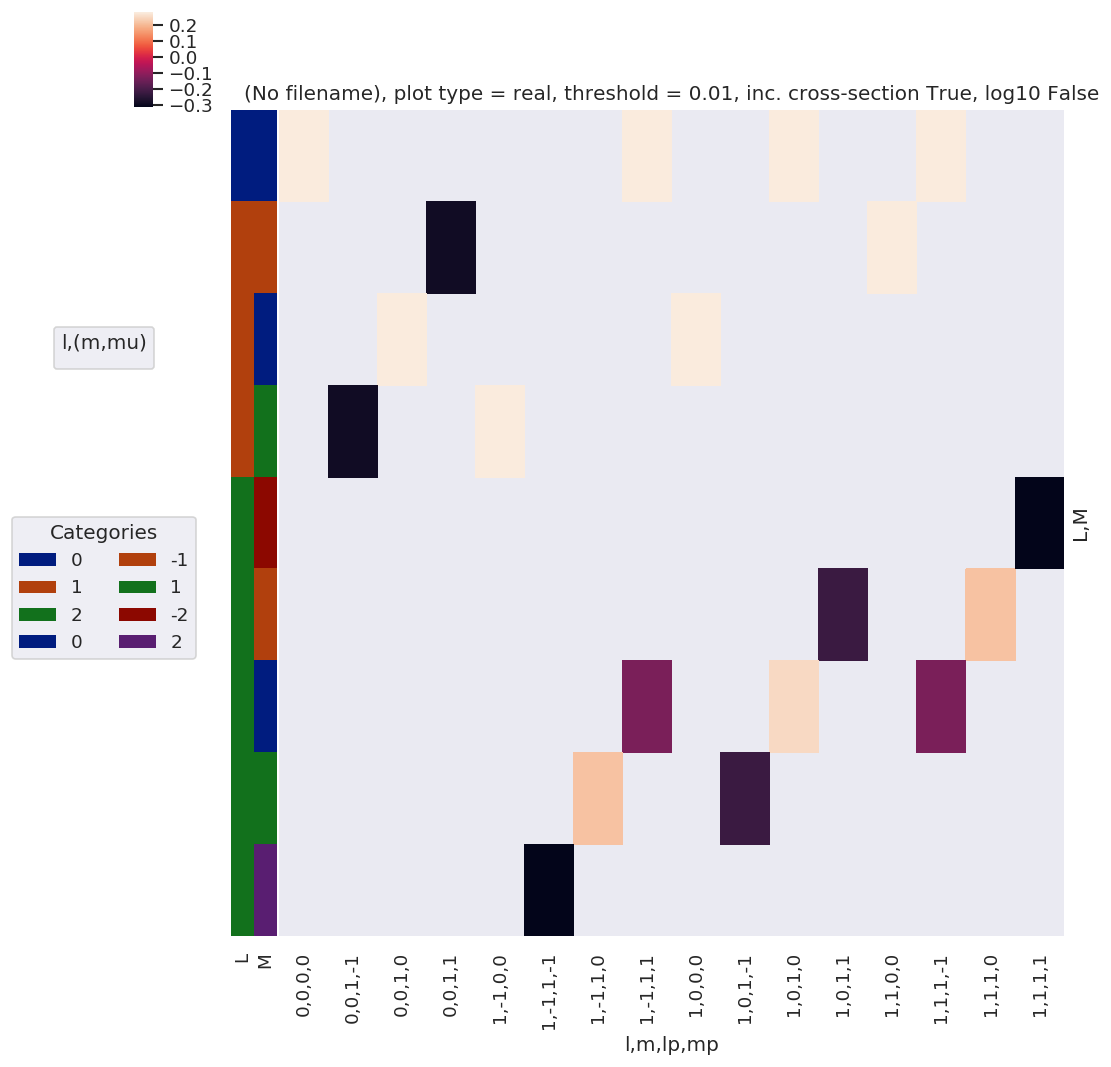

In [30]:
# Switch plotting dims
plotDimsRed = ['L','M']
xDim = {'llpmmp':['l', 'm', 'lp', 'mp']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, plotDims=plotDimsRed, xDim=xDim, mMax = 2, pType = 'r')

## $\Lambda$ Term

Define MF projection term, $\Lambda_{R',R}(R_{\hat{n}})$:

\begin{equation}
\Lambda_{R',R}(R_{\hat{n}})=(-1)^{(R')}\left(\begin{array}{ccc}
1 & 1 & P\\
\mu & -\mu' & R'
\end{array}\right)D_{-R',-R}^{P}(R_{\hat{n}})
\end{equation}


## $\beta_{L,M}^{MF}$ rewrite

The various terms defined above can be used to redefine the full MF observables, expressed as a set of $\beta_{L,M}$ coefficients.

The original (full) form for the MF equation, as implemented in `ePSproc`:

\begin{eqnarray}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & = & \sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{M}(-1)^{m}(-1)^{(\mu'-\mu_{0})}\left(\frac{(2l+1)(2l'+1)(2L+1)}{4\pi}\right)^{1/2}\left(\begin{array}{ccc}
l & l' & L\\
0 & 0 & 0
\end{array}\right)\left(\begin{array}{ccc}
l & l' & L\\
-m & m' & -M
\end{array}\right)\nonumber \\
 & \times & \sum_{P,R',R}(2P+1)(-1)^{(R'-R)}\left(\begin{array}{ccc}
1 & 1 & P\\
\mu & -\mu' & R'
\end{array}\right)\left(\begin{array}{ccc}
1 & 1 & P\\
\mu_{0} & -\mu_{0} & R
\end{array}\right)D_{-R',-R}^{P}(R_{\hat{n}})I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)
\end{eqnarray}

Where $I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)$ are the energy-dependent dipole matrix elements.

Substituting the terms above (plus some tidying up with phases etc. - see other notes for full derivation):

\begin{eqnarray}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & = & \sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{(\mu'-\mu_{0})}{\color{red}B_{L,-M}}\nonumber \\
 & \times & \sum_{P,R',R}{\color{red}E_{P-R}(\hat{e})\Lambda_{R',R}(R_{\hat{n}})}I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)
\end{eqnarray}

And can also reorder...

\begin{eqnarray*}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & = & \sum_{P,R',R}{\color{red}E_{P-R}(\hat{e})}\sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{(\mu'-\mu_{0})}{\color{red}B_{L,-M}\Lambda_{R',R}(R_{\hat{n}})}I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)
\end{eqnarray*}

Add additional (function) labels to track QNs:

\begin{eqnarray*}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & = & \sum_{P,R',R}{\color{red}E_{P-R}(\hat{e};\mu_{0})}\sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{(\mu'-\mu_{0})}{\color{red}\Lambda_{R',R}(R_{\hat{n}};\mu,P,R,R')B_{L,-M}(l,l',m,m')}I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)
\end{eqnarray*}


Cf. R\&U rotational wavepacket case, see also Chpt. 12 in Quantum
Met book for similar formalism separating geometric channels:

\begin{equation}
\varUpsilon_{L,M}^{u}=\sum_{ll'}\sum_{\lambda\lambda'}\sum_{mm'}(-1)^{m}\sqrt{\frac{(2l+1)(2l'+1)(2L+1)}{4\pi}}\left(\begin{array}{ccc}
l & l' & L\\
m & -m' & M
\end{array}\right)\left(\begin{array}{ccc}
l & l' & L\\
0 & 0 & 0
\end{array}\right)\gamma_{\alpha_{+}l\lambda ml'\lambda'm'}^{u}\label{eq:geom-channels}
\end{equation}

\begin{equation}
\Lambda^{\zeta\zeta'}=\sum_{\Gamma,\Gamma'}\sum_{\mu,\mu'}\sum_{h,h'}b_{hl\lambda}^{\Gamma\mu*}b_{h'l'\lambda'}^{\Gamma'\mu'}\boldsymbol{D}_{hl}^{\Gamma\mu*}(q,\,k)\boldsymbol{D}_{h'l'}^{\Gamma'\mu'}(q',\,k)
\end{equation}

\begin{equation}
\beta_{L,M}^{u}=\sum_{\zeta,\zeta'}\varUpsilon_{L,M}^{u,\zeta\zeta'}\Lambda^{\zeta\zeta'}
\end{equation}

## Other plotting methods...

### Holoviews
Should be a good option, but previously had issues with multlevel coords, so may need to do some work here.


In [15]:
import holoviews as hv

In [16]:
hv_ds = hv.Dataset(daPlotpd.unstack())

ValueError: Dimensions specified as a tuple must be a tuple consisting of the name and label not: (0, 0, 0, 0, -2)

### Pandas

In [ ]:
daPlotpd.plot(kind = 'bar')